<a href="https://colab.research.google.com/github/Letch49/ML-vvsu-2025-2026/blob/master/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 4

1. Преобразовать датасет (процессинг категориальных признаков, копия данных в df_not_processed, scale датасета)
2. Сделать k-means кластеризацию (записать cluster в df_not_processed, вывести статистику, графики. попробовать объяснить принцип кластеризации), оценить метриками, вывести результат
3. Подобрать оптимальное число кластеров с помощью "метод локтя", вывести статистику, графики, метрики, объяснить результат
4. Сделать DBSSCAN кластеризацию, подобрать оптимальные параметры, посчитать метрики, вывести статистику, объяснить результат
5. Ответить на вопрос - какой из методов кластеризации больше подходит для вашего датасета

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

In [41]:
df = pd.read_csv('Customers.csv')

### **1. Преобразование датасета**:

In [42]:
df_not_processed = df.copy() # копия данных

In [43]:
print("Размерность:", df.shape, "\n")
print("Типы:\n", df.dtypes, "\n")
print("Пропуски:\n", df.isna().sum(), "\n")

Размерность: (2000, 8) 

Типы:
 CustomerID                 int64
Gender                    object
Age                        int64
Annual Income ($)          int64
Spending Score (1-100)     int64
Profession                object
Work Experience            int64
Family Size                int64
dtype: object 

Пропуски:
 CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64 



In [44]:
# Заполним пропуски
df["Profession"] = df["Profession"].fillna("Unknown")

In [45]:
# Удалим лишний столбец
df.drop(columns=['CustomerID'], inplace=True)

In [46]:
df["Gender"] = df["Gender"].astype("category")
df["Profession"] = df["Profession"].astype("category")

In [47]:
# One-Hot Encoding
category_columns: list[str] = df.select_dtypes(include=['category']).columns # собираем колонки помеченные как category
# Применяем
df = pd.get_dummies(df, columns=category_columns, drop_first=True)

In [48]:
# Scale датасета

# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Инициализируем scaler
scaler = StandardScaler()
# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [49]:
print("Готово! После преобразования форма данных:", df.shape)
display(df.head())

Готово! После преобразования форма данных: (2000, 15)


,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size,Gender_Male,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Unknown
0,-1.054089,-2.093501,-0.428339,-0.791207,0.117497,True,False,False,False,False,True,False,False,False,False
1,-0.983723,-1.656133,1.075546,-0.281162,-0.390051,True,False,True,False,False,False,False,False,False,False
2,-1.018906,-0.540845,-1.609962,-0.791207,-1.405148,False,False,True,False,False,False,False,False,False,False
3,-0.913356,-1.131292,0.932319,-1.046230,-0.897599,False,False,False,False,False,False,False,True,False,False
4,-0.631891,-1.590528,-0.392532,-0.536185,1.132594,False,False,False,True,False,False,False,False,False,False


### **2. KMeans кластеризация**

**Цель:** Сгруппировать похожие элементы в заранее заданное количество (K) кластеров. Модель ищет центроиды (середины или средние значения) получившихся кластеров.

**Основные характеристики и принцип работы:**

1.  Форма кластеров: K-Means лучше всего работает с кластерами шарообразной формы. Если данные имеют более сложную структуру, могут потребоваться другие алгоритмы, такие как DBSCAN.
2.  Принцип работы:
    *   Инициализация: Изначально выбираются K центроидов. Поскольку модель чувствительна к начальной инициализации, часто применяется более интеллектуальный подход K-Means++, который выбирает центроиды, максимально удаленные друг от друга.
    *   Присвоение точек: Каждая точка данных присваивается тому кластеру, к центроиду которого она находится на минимальном расстоянии.
    *   Пересчет центроидов: Центроиды перемещаются в центр масс (среднее значение координат) всех точек, которые были к ним присвоены.
    
    Шаги повторяются до тех пор, пока центроиды перестают двигаться или их смещение становится незначительным.
3.  Выбор оптимального K (Метод локтя):
    *   Метод основан на расчете внутрикластерной дисперсии, также известной как инерция.
    *   Инерция измеряет сумму квадратов расстояний от каждой точки до ее центроида.
    *   Оптимальное K соответствует точке на графике, где наблюдается резкое падение дисперсии, после которого падение становится более плавным — это и есть «локоть».

**KMeans**

In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [62]:
k_base = 3

In [63]:
km = KMeans(n_clusters=k_base, n_init=10, random_state=42)
labels_km = km.fit_predict(df)

In [71]:
# Записываем кластеры в копию
df_not_processed['cluster_kmeans_base'] = labels_km

In [77]:
# Выводим метрики
sil = silhouette_score(df, labels_km)
ch  = calinski_harabasz_score(df, labels_km)
db  = davies_bouldin_score(df, labels_km)

print(f"Silhouette Score: {sil:.3f}")
print(f"Calinski–Harabasz Index: {ch:.1f}")
print(f"Davies–Bouldin Index: {db:.3f}")

Silhouette Score: 0.127
Calinski–Harabasz Index: 289.5
Davies–Bouldin Index: 2.112


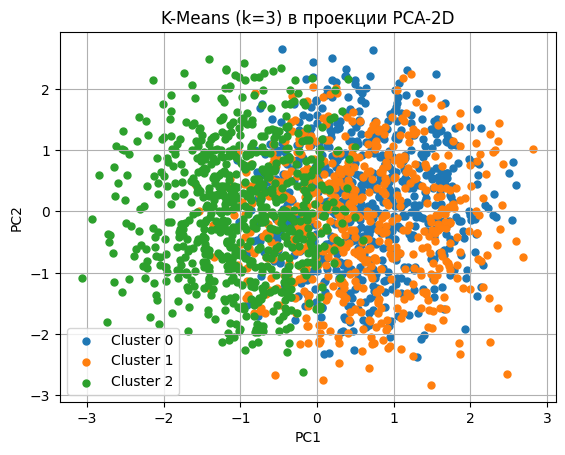

In [72]:
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(df)

for lab in np.unique(labels_km):
    mask = labels_km == lab
    plt.scatter(X2[mask, 0], X2[mask, 1], s=25, label=f'Cluster {lab}')
plt.title(f'K-Means (k={k_base}) в проекции PCA-2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
sizes = (
    df_not_processed['cluster_kmeans_base']
    .value_counts()
    .rename_axis('cluster')
    .reset_index(name='size')
    .sort_values('cluster')
)
display(sizes)

,cluster,size
1,0,675
2,1,607
0,2,718


In [89]:
# Средние значения числовых переменных
num_cols = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']
df_not_processed.groupby('cluster_kmeans_base')[num_cols].mean().round(1)

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
cluster_kmeans_base,,,,,
0,52.7,123012.8,53.0,2.7,5.8
1,48.2,119574.6,45.9,8.7,3.3
2,46.1,91710.6,53.3,1.6,2.3


Распределение категориальных признаков

In [93]:
pd.crosstab(df_not_processed['cluster_kmeans_base'], df_not_processed['Gender'], normalize='index').round(2)

Gender,Female,Male
cluster_kmeans_base,,
0,0.60,0.40
1,0.58,0.42
2,0.60,0.40


In [92]:
pd.crosstab(df_not_processed['cluster_kmeans_base'], df_not_processed['Profession'], normalize='index').round(2)

Profession,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
cluster_kmeans_base,,,,,,,,,
0,0.27,0.08,0.10,0.14,0.08,0.18,0.02,0.08,0.04
1,0.32,0.08,0.09,0.10,0.08,0.17,0.05,0.06,0.05
2,0.34,0.09,0.09,0.11,0.07,0.17,0.02,0.07,0.04


**Интерпретация:**

Кластер 0 — самая взрослая группа клиентов (средний возраст ≈ 52.7 года) с высоким доходом и большим размером семьи, но малым опытом работы.
Это может быть группа состоятельных клиентов старшего возраста, например, владельцев семейного бизнеса или состоявшихся специалистов.

Кластер 1 — группа с умеренным возрастом и самым большим опытом работы (≈8.7 лет). При этом они имеют средний доход и умеренные траты — вероятно, это наиболее «сбалансированные» клиенты.

Кластер 2 — самая молодая группа с низким доходом, высоким уровнем трат и наименьшим опытом работы.

**Общий вывод:**

При k=3 алгоритм выделил группы, различающиеся по возрасту, доходу и опыту работы, однако границы между ними остаются размытыми.

Пол не влияет на разделение

Различия по профессии незначительны.

**Выводы по K-Means с k=3:**

*   **Метрики:** Полученные метрики (Silhouette Score: 0.127, Calinski–Harabasz Index: 289.5, Davies–Bouldin Index: 2.112) указывают на то, что кластеризация с 3 кластерами не является очень четкой. Значение Silhouette Score низкое, что говорит о слабом разделении между кластерами. Davies–Bouldin Index выше 1, что также свидетельствует о неоптимальном разделении.
*   **Визуализация:** На графике PCA видно, что кластеры сильно перекрываются, что подтверждает низкие значения метрик и указывает на то, что данные не формируют четко выраженные шарообразные группы в 2D проекции.
*   **Статистика по кластерам:**
    *   Кластеры имеют относительно схожий размер.
    *   Средние значения числовых признаков (возраст, доход, оценка трат, опыт работы, размер семьи) показывают некоторые различия между кластерами, но эти различия не очень ярко выражены. Например, кластер 0 имеет самый высокий средний возраст и размер семьи, но самый низкий опыт работы. Кластер 1 имеет самый высокий опыт работы, а кластер 2 - самый низкий возраст и размер семьи.
    *   Распределение по полу и профессиям очень похоже во всех трех кластерах, что говорит о том, что эти признаки не являются основными драйверами разделения на 3 кластера.

На основе этих наблюдений можно сказать, что при k=3 K-Means не смог выделить три хорошо разделенные и интерпретируемые группы клиентов.

### **3. Метод локтя**

**Подберем число кластеров**

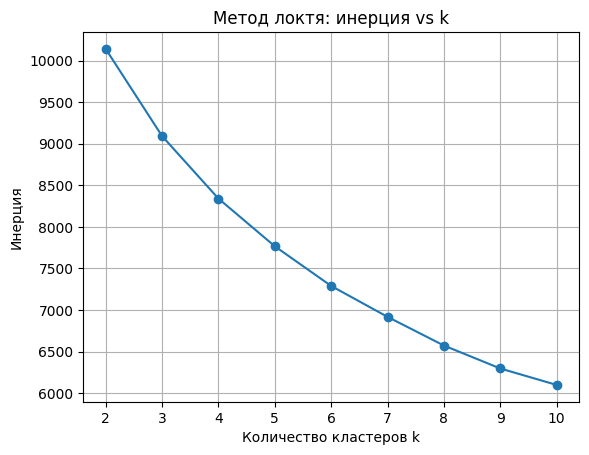

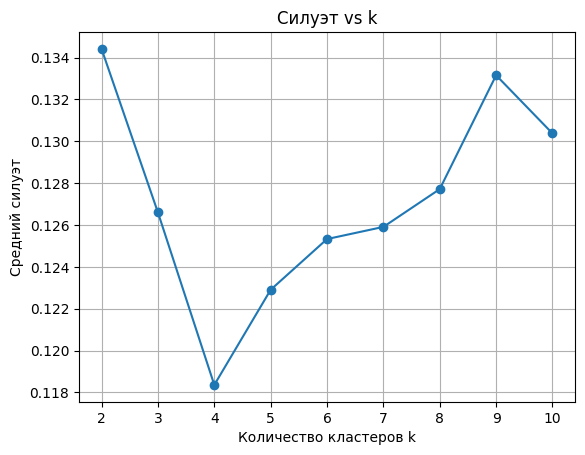

In [99]:
# Диапазон возможных k
k_values = list(range(2, 11))
inertias, silhouettes = [], []
labels_by_k = {}

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(df)
    labels_by_k[k] = labels
    inertias.append(km.inertia_)
    try:
        silhouettes.append(silhouette_score(df, labels))
    except Exception:
        silhouettes.append(np.nan)

# График метода локтя
plt.plot(k_values, inertias, marker='o')
plt.title('Метод локтя: инерция vs k')
plt.xlabel('Количество кластеров k')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

# График силуэта
plt.plot(k_values, silhouettes, marker='o')
plt.title('Силуэт vs k')
plt.xlabel('Количество кластеров k')
plt.ylabel('Средний силуэт')
plt.grid(True)
plt.show()


Метод локтя не показал четкого излома, но по силуэту видно, что оптимальное число кластеров = 2. k=2 дает наилучший баланс между компактностью кластеров и их разделимостью.

In [100]:
best_k = 2

**Теперь делаем кластеризацию с оптимальным кол-вом**

[k=2] Silhouette=0.134 | CH=312.9 | DB=2.451


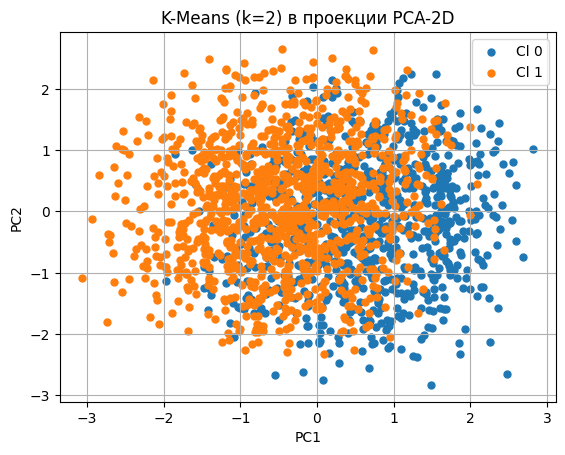

In [81]:
km_opt = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit(df)
labels_opt = km_opt.labels_

df_not_processed['cluster_kmeans_opt'] = labels_opt

sil_opt = silhouette_score(df, labels_opt)
ch_opt  = calinski_harabasz_score(df, labels_opt)
db_opt  = davies_bouldin_score(df, labels_opt)
print(f'[k={best_k}] Silhouette={sil_opt:.3f} | CH={ch_opt:.1f} | DB={db_opt:.3f}')

X2 = PCA(n_components=2, random_state=42).fit_transform(df)
for lab in np.unique(labels_opt):
    m = labels_opt == lab
    plt.scatter(X2[m,0], X2[m,1], s=25, label=f'Cl {lab}')
plt.title(f'K-Means (k={best_k}) в проекции PCA-2D')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.show()


In [82]:
sizes = (
    df_not_processed['cluster_kmeans_opt']
    .value_counts()
    .rename_axis('cluster')
    .reset_index(name='size')
    .sort_values('cluster')
)
display(sizes)

,cluster,size
1,0,846
0,1,1154


In [94]:
# Средние значения числовых переменных
num_cols = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']
df_not_processed.groupby('cluster_kmeans_opt')[num_cols].mean().round(1)

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
cluster_kmeans_opt,,,,,
0,48.6,118714.1,49.0,8.1,3.9
1,49.2,104880.0,52.4,1.2,3.7


Распределение категориальных признаков

In [96]:
pd.crosstab(df_not_processed['cluster_kmeans_opt'], df_not_processed['Gender'], normalize='index').round(2)

Gender,Female,Male
cluster_kmeans_opt,,
0,0.58,0.42
1,0.60,0.40


In [97]:
pd.crosstab(df_not_processed['cluster_kmeans_opt'], df_not_processed['Profession'], normalize='index').round(2)

Profession,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
cluster_kmeans_opt,,,,,,,,,
0,0.32,0.08,0.09,0.10,0.09,0.17,0.05,0.06,0.05
1,0.31,0.08,0.09,0.14,0.07,0.17,0.02,0.08,0.04


**Интерпретация:**

Кластер 0 — клиенты с высоким доходом и опытом работы (8 лет), более «практичные» в расходах (Spending = 49).

Кластер 1 — клиенты с ниже доходом и почти без опыта работы (1 год), но с чуть более высокими расходами (Spending = 52.4).

**Общий вывод:**

При k=2 кластеры стали более контрастными именно по опыту работы и уровню дохода, но другие признаки всё ещё не дают чётких границ.

**Выводы по K-Means с оптимальным k=2:**

*   **Оптимальное k:** Метод силуэта показал, что k=2 является оптимальным количеством кластеров для данного датасета с точки зрения этого критерия.
*   **Метрики:** Метрики при k=2 (Silhouette=0.134, CH=312.9, DB=2.451) немного отличаются от метрик при k=3. Silhouette Score немного вырос, но все равно остается довольно низким, что указывает на по-прежнему не очень четкое разделение. Calinski-Harabasz Index вырос, а Davies-Bouldin Index также увеличился, что, в данном случае, может свидетельствовать о том, что 2 кластера менее компактны и более разбросаны, чем 3.
*   **Визуализация:** На графике PCA с k=2 видно два больших перекрывающихся кластера. Визуально разделение не выглядит идеальным.
*   **Статистика по кластерам:**
    *   Кластеры имеют разные размеры (один больше другого).
    *   Средние значения числовых признаков показывают более заметные различия по сравнению с k=3. Кластер 0 имеет в среднем более высокий опыт работы и размер семьи, но немного ниже возраст, доход и оценку трат по сравнению с кластером 1. Кластер 1, наоборот, имеет более низкий опыт работы и размер семьи, но немного выше возраст, доход и оценку трат.
    *   Распределение по полу и профессиям по-прежнему очень похоже в обоих кластерах, что подтверждает вывод о том, что эти признаки не сильно влияют на разделение.

На основе анализа статистики можно предположить, что K-Means при k=2 пытается разделить клиентов в основном по признакам "Опыт работы" и "Размер семьи", возможно, в сочетании с "Возрастом", но из-за перекрытия и нечеткой структуры данных, разделение не получается очень хорошим.

**Сравнение**

При базовом числе k = 3 алгоритм выделил три группы клиентов, однако полученные метрики (Silhouette ≈ 0.13, Davies–Bouldin ≈ 2.1) показали слабое разделение между кластерами. Анализ средних значений признаков подтвердил, что различия между группами незначительны, а на PCA-графике наблюдается существенное перекрытие точек.

Разделение на два кластера даёт немного лучшее качество, хотя кластеры по-прежнему пересекаются.

Таким образом, можно сделать вывод, что данные не имеют ярко выраженной кластерной структуры, а K-Means не способен сформировать чёткие и компактные группы. Тем не менее, k = 2 можно считать условно оптимальным числом кластеров, поскольку оно обеспечивает наилучший баланс между простотой модели и метриками качества.

### **DBSCAN**

In [101]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(df)

np.unique(labels_db, return_counts=True)

(array([-1]), array([2000]))

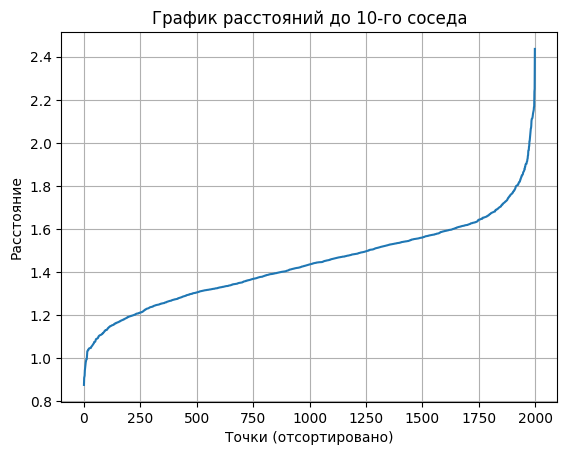

In [112]:
# Построим график k-расстояний для k = 10
k_distance = 10 # Установим k равным 10 для графика k-расстояний
nn_k = NearestNeighbors(n_neighbors=k_distance)
nn_k.fit(df)
distances_k, indices_k = nn_k.kneighbors(df)
distances_k = np.sort(distances_k[:, k_distance-1])  # расстояния до 10-го соседа

plt.plot(distances_k)
plt.title(f'График расстояний до {k_distance}-го соседа')
plt.xlabel('Точки (отсортировано)')
plt.ylabel('Расстояние')
plt.grid(True)
plt.show()

In [122]:
# Перебор min_samples и eps для DBSCAN
min_samples_values = range(5, 21, 5) # Попробуем min_samples от 5 до 20 с шагом 5
eps_values = [0.5, 0.8, 1.0, 1.3, 1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.4]

for min_samples in min_samples_values:
    print(f"\n--- min_samples = {min_samples} ---")
    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
        n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        n_noise = (db.labels_ == -1).sum()
        print(f"  eps={eps:.1f}: clusters={n_clusters}, noise={n_noise}")


--- min_samples = 5 ---
  eps=0.5: clusters=0, noise=2000
  eps=0.8: clusters=16, noise=1896
  eps=1.0: clusters=31, noise=1546
  eps=1.3: clusters=2, noise=298
  eps=1.5: clusters=1, noise=47
  eps=1.7: clusters=1, noise=13
  eps=1.8: clusters=1, noise=7
  eps=1.9: clusters=1, noise=2
  eps=2.0: clusters=1, noise=0
  eps=2.1: clusters=1, noise=0
  eps=2.2: clusters=1, noise=0
  eps=2.4: clusters=1, noise=0

--- min_samples = 10 ---
  eps=0.5: clusters=0, noise=2000
  eps=0.8: clusters=0, noise=2000
  eps=1.0: clusters=2, noise=1952
  eps=1.3: clusters=3, noise=667
  eps=1.5: clusters=1, noise=102
  eps=1.7: clusters=1, noise=22
  eps=1.8: clusters=1, noise=10
  eps=1.9: clusters=1, noise=4
  eps=2.0: clusters=1, noise=0
  eps=2.1: clusters=1, noise=0
  eps=2.2: clusters=1, noise=0
  eps=2.4: clusters=1, noise=0

--- min_samples = 15 ---
  eps=0.5: clusters=0, noise=2000
  eps=0.8: clusters=0, noise=2000
  eps=1.0: clusters=0, noise=2000
  eps=1.3: clusters=1, noise=1010
  eps=1.5: cl

Единственные нормальные параметры выявлены - eps=1.3, min_samples = 5

In [123]:
db = DBSCAN(eps=1.3, min_samples=5).fit(df)
df_not_processed['cluster_dbscan'] = db.labels_

In [124]:
# Метрики
mask = db.labels_ != -1
sil = silhouette_score(df[mask], db.labels_[mask])
ch  = calinski_harabasz_score(df[mask], db.labels_[mask])
dbi = davies_bouldin_score(df[mask], db.labels_[mask])
print(f"Silhouette={sil:.3f}, CH={ch:.1f}, DB={dbi:.3f}")

Silhouette=0.101, CH=4.4, DB=1.032


Значение Silhouette=0.101 говорит о очень слабом разделении кластеров.

Здесь значение CH=4.4 указывает, что различия между кластерами слабо выражены.

Значение DB=1.032 — неплохое, особенно учитывая, что у K-Means оно было 2.4.

Метрики показывают, что DBSCAN с параметрами eps = 1.3, min_samples = 5 выделил две слабовыраженные группы, которые немного лучше отделены, чем при K-Means, но общая структура данных всё ещё размыта.

Значение Silhouette низкое, а CH близок к нулю, что говорит об отсутствии ярко выраженных подмножеств.
Однако Davies–Bouldin < 1.1 показывает, что плотность и форма кластеров DBSCAN чуть лучше, чем у K-Means, а наличие «шума» делает модель более реалистичной (учитывает выбросы).

In [128]:
sizes = (
    df_not_processed['cluster_dbscan']
    .value_counts()
    .rename_axis('cluster')
    .reset_index(name='size')
    .sort_values('cluster')
)
display(sizes)

,cluster,size
1,-1,298
0,0,1699
2,1,3


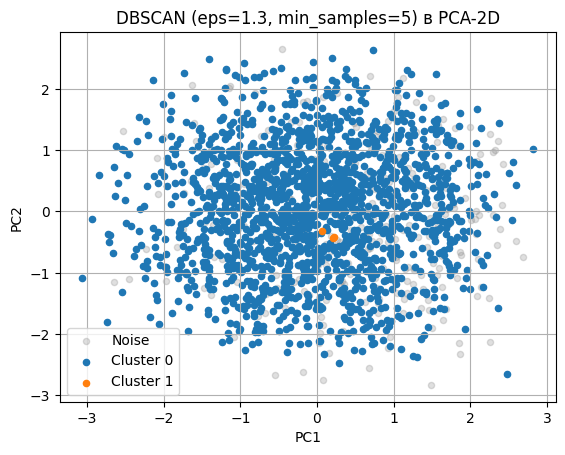

In [125]:
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(df)

for lab in np.unique(db.labels_):
    mask = db.labels_ == lab
    if lab == -1:
        plt.scatter(X2[mask,0], X2[mask,1], s=20, alpha=0.25, color='gray', label='Noise')
    else:
        plt.scatter(X2[mask,0], X2[mask,1], s=20, label=f'Cluster {lab}')
plt.title('DBSCAN (eps=1.3, min_samples=5) в PCA-2D')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.show()

Видно, что алгоритм выделил два кластера - одну большую и вторую - c численностью 3, что слишком мало. Это не группа.

In [126]:
num_cols = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']
df_not_processed.groupby('cluster_dbscan')[num_cols].mean().round(1)

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
cluster_dbscan,,,,,
-1,45.0,110028.4,47.9,7.2,4.1
0,49.7,110734.2,51.6,3.6,3.7
1,16.3,179276.0,13.3,5.0,1.0


In [127]:
pd.crosstab(df_not_processed['cluster_dbscan'], df_not_processed['Gender'], normalize='index').round(2)
pd.crosstab(df_not_processed['cluster_dbscan'], df_not_processed['Profession'], normalize='index').round(2)

Profession,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
cluster_dbscan,,,,,,,,,
-1,0.07,0.18,0.11,0.12,0.12,0.08,0.09,0.13,0.11
0,0.35,0.06,0.09,0.12,0.07,0.19,0.02,0.06,0.03
1,0.67,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00


Кластер 1 из 3 точек - это не реальная группа, а аномальный выброс, состоящий из нескольких “уникальных” объектов, оказавшихся рядом друг с другом.
То есть, по сути DBSCAN нашёл только один значимый кластер и область шума, а не полноценное разделение на две устойчивые группы.

При других eps всё сливается и находится 1 кластер.

### **K-Means vs DBSCAN**

Для данного набора данных (клиенты — возраст, доход, траты и т.д.) алгоритм K-Means показал себя лучше, чем DBSCAN.
Он смог разделить клиентов на две приблизительно равные группы, пусть и с умеренными показателями метрик (Silhouette ≈ 0.13).

Алгоритм DBSCAN оказался менее подходящим, так как при разных параметрах почти весь набор данных объединяется в один кластер. Это говорит о равномерном распределении признаков, где нет выраженных плотных областей.

Таким образом, для этого датасета предпочтителен K-Means, так как он позволяет хотя бы отдаленно выявить закономерности между клиентами.